In [1]:

import torch
import gc   
torch.cuda.empty_cache()
gc.collect()


0

In [2]:
print('dsdsdddddds')

dsdsdddddds


In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"

# Step 2: Import necessary libraries
from typing import Optional, Dict, Any
import os
import torch
import pytorch_lightning as pl
import pandas as pd
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from rich.traceback import install
from pytorch_lightning.loggers import WandbLogger
import torch.nn as nn
import torch.optim as optim
from transformers import AutoConfig, get_cosine_schedule_with_warmup
from adapters import AutoAdapterModel, AdapterConfig
from adapters.composition import Stack
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

install(show_locals=True)

from setup import setup_src_path
print(setup_src_path())
import data.processed as processed
import config.config as config
import utils.setup as setup
import utils.functions as fn
from importlib import reload

from datasets import load_from_disk

print(config.Config.TXT_SAVE_PATH)
print(config.Config.MODEL_SAVE_PATH)

dataset = load_from_disk(f"../{config.Config.DATASETS_SAVE_PATH}/datasets")


['/home/guest/Desktop/projects/fourth-expeiments/domain_adaptation_project/union/fiction', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages', '/tmp/tmp6ecbfrr8', '/home/guest/Desktop/projects/fourth-expeiments/domain_adaptation_project/modules']


2024-07-14 12:06:13.847557: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 12:06:13.880579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 12:06:14.458376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


./text-files/
./hp-model-


In [4]:
print('dsds')

dsds


In [5]:
# Step 4: Define the DomainTaskAdapter class



class DomainTaskAdapter(pl.LightningModule):
    def __init__(self, hparams):
        super(DomainTaskAdapter, self).__init__()
        self.save_hyperparameters(hparams)
        self.config = AutoConfig.from_pretrained(self.hparams["pretrained_model_name"])
        self.config.output_hidden_states = True
        self.model = AutoAdapterModel.from_pretrained(self.hparams["pretrained_model_name"], config=self.config)
        
        self.reduction_factor = self.hparams.get("reduction_factor", 16)
        if self.reduction_factor == "None":
            self.reduction_factor = 16
        self.leave_out = self.hparams.get("leave_out", [])
       
        self.saved_adapter_dir = self.hparams["saved_adapter_dir"]
        self.domain_adapter_name = self.hparams["domain_adapter_name"]
        
        adapter_config = AdapterConfig.load("seq_bn")
        
        self.task_adapter_name = self.hparams["task_adapter_name"]
        #self.model.add_adapter(self.task_adapter_name, config=adapter_config)

        self.model.load_adapter(f"{self.saved_adapter_dir}/{self.domain_adapter_name}", with_head=False)
        self.model.add_classification_head(self.task_adapter_name, num_labels=self.hparams["num_classes"])
        self.model.active_adapters = self.domain_adapter_name

        self.model.train_adapter(self.domain_adapter_name)
        print(self.model.adapter_summary())
        print(fn.print_trainable_parameters(self.model))

        self.training_outputs = []
        self.validation_outputs = []
        self.test_outputs = []
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass',                                           
                                     num_classes=self.hparams["num_classes"])
        self.f1 = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="weighted")
        self.f1_macro = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="macro")
        self.f1_micro = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="micro")
        self.softmax = nn.Softmax(dim=1)
        self.entropy_values = []  # For entropy minimization
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits,outputs.hidden_states[-1]

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        labels = batch["label_source"]
        logits,_ = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = self.criterion(logits, labels)
        accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        # self.training_outputs.append({
        #     "train_loss": loss,
        #     "train_accuracy":accuracy,
        #     "train_f1":f1,
        #     })
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        self.log("train_f1", f1)
        
        return loss
   
    def validation_step(self, batch, batch_idx):
        """validation step of DomainTaskAdapter"""
        # get the input ids and attention mask for source data
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        logits,features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_source"]
        source_loss = self.criterion(logits, labels)
        source_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))


        # get the input ids and attention mask for target data
        input_ids, attention_mask = batch["target_input_ids"], batch["target_attention_mask"]
        logits ,target_features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_target"]
        target_loss = self.criterion(logits, labels)
        target_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        # # Entropy minimization - calculate and log entropy
        # probs = self.softmax(logits).cpu().numpy()
        # entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
        # avg_entropy = np.mean(entropy)
        # self.entropy_values.append(avg_entropy)
     
        # this will log the mean div value across epoch
        self.log(name="source_val/loss", value=source_loss, prog_bar=True, logger=True)
        self.log(name="source_val/accuracy", value=source_accuracy, prog_bar=True, logger=True)
        self.log(name="source_val/f1", value=source_f1, prog_bar=True, logger=True)
        self.log(name="target_val/loss", value=target_loss, prog_bar=True, logger=True)
        self.log(name="target_val/accuracy", value=target_accuracy, prog_bar=True, logger=True)
        self.log(name="target_val/f1", value=target_f1, prog_bar=True, logger=True)
        
        self.validation_outputs.append({
            "source_val/loss": source_loss,
            "source_val/accuracy": source_accuracy,
            "source_val/f1": source_f1,
            "target_val/loss": target_loss,
            "target_val/accuracy": target_accuracy,
            "target_val/f1": target_f1,
            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
                })
        return {
            "source_val/loss": source_loss,
            "source_val/accuracy": source_accuracy,
            "source_val/f1": source_f1,
            "target_val/loss": target_loss,
            "target_val/accuracy": target_accuracy,
            "target_val/f1": target_f1,
            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
                            }
    def on_validation_epoch_start(self):
        self.validation_outputs = []
    
    def on_validation_epoch_end(self):
        try:
            outputs= self.validation_outputs
            mean_source_loss = torch.stack([x["source_val/loss"] for x in outputs]).mean()
            mean_source_accuracy = torch.stack([x["source_val/accuracy"] for x in outputs]).mean()
            mean_source_f1 = torch.stack([x["source_val/f1"] for x in outputs]).mean()

            mean_target_loss = torch.stack([x["target_val/loss"] for x in outputs]).mean()
            mean_target_accuracy = torch.stack([x["target_val/accuracy"] for x in outputs]).mean()
            mean_target_f1 = torch.stack([x["target_val/f1"] for x in outputs]).mean()
            print(f"target_val/loss: {mean_target_loss}")
            print(f"target_val/accuracy: {mean_target_accuracy}")
            print(f"target_val/f1: {mean_target_f1}")
            print(f"source_val/loss: {mean_source_loss}")
            print(f"source_val/accuracy: {mean_source_accuracy}")
            print(f"source_val/f1: {mean_source_f1}")

            self.log(name="source_val/loss", value=mean_source_loss, prog_bar=True, logger=True)
            self.log(name="source_val/accuracy", value=mean_source_accuracy, prog_bar=True, logger=True)
            self.log(name="target_val/loss", value=mean_target_loss, prog_bar=True, logger=True)
            self.log(name="target_val/accuracy", value=mean_target_accuracy, prog_bar=True, logger=True)
            self.log(name="target_val/f1", value=mean_target_f1, prog_bar=True, logger=True)
            self.log(name="source_val/f1", value=mean_source_f1, prog_bar=True, logger=True)
        
        
            self.log("val_loss", mean_source_loss)
            #Generate and log visualizations
            if hasattr(self.trainer, 'current_epoch'):
                self.plot_tsne(outputs, epoch=self.trainer.current_epoch, phase='validation')
                self.plot_confusion_matrix(outputs, phase='validation')
        except Exception as e:
            print(f"Error during on_validation_epoch_end: {e}")
            raise

    def test_step(self, batch, batch_idx):
        """validation step of DomainTaskAdapter"""
        # get the input ids and attention mask for source data
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        logits,features  = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_source"]
        source_loss = self.criterion(logits, labels)
        source_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1_macro = self.f1_macro(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1_micro = self.f1_micro(labels, torch.argmax(self.softmax(logits), dim=1))

        # get the input ids and attention mask for target data
        input_ids, attention_mask = batch["target_input_ids"], batch["target_attention_mask"]
        logits,target_features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_target"]
        target_loss = self.criterion(logits, labels)
        target_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1_macro = self.f1_macro(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1_micro = self.f1_micro(labels, torch.argmax(self.softmax(logits), dim=1))

       

        self.log(name="source_test/loss", value=source_loss, logger=True)
        self.log(name="source_test/accuracy", value=source_accuracy, logger=True)
        self.log(name="source_test/f1", value=source_f1, logger=True)
        self.log(name="source_test/f1_macro", value=source_f1_macro, logger=True)
        self.log(name="source_test/f1_micro", value=source_f1_micro, logger=True)
        self.log(name="target_test/loss", value=target_loss, logger=True)
        self.log(name="target_test/accuracy", value=target_accuracy, logger=True)
        self.log(name="target_test/f1", value=target_f1, logger=True)
        self.log(name="target_test/f1_macro", value=target_f1_macro, logger=True)
        self.log(name="target_test/f1_micro", value=target_f1_micro, logger=True)
        
        self.test_outputs.append({
            "source_test/loss": source_loss,
            "source_test/accuracy": source_accuracy,
            "source_test/f1": source_f1,
            "source_test/f1_macro": source_f1_macro,
            "source_test/f1_micro": source_f1_micro,
            "target_test/loss": target_loss,
            "target_test/accuracy": target_accuracy,
            "target_test/f1": target_f1,
            "target_test/f1_macro": target_f1_macro,
            "target_test/f1_micro": target_f1_micro,

            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
        })
        return {
            "source_test/loss": source_loss,
            "source_test/accuracy": source_accuracy,
            "source_test/f1": source_f1,
            "source_test/f1_macro": source_f1_macro,
            "source_test/f1_micro": source_f1_micro,

            "target_test/loss": target_loss,
            "target_test/accuracy": target_accuracy,
            "target_test/f1": target_f1,
            "target_test/f1_macro": target_f1_macro,
            "target_test/f1_micro": target_f1_micro,

            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
        }
    def on_test_epoch_start(self):
        self.test_outputs = []
    def on_test_epoch_end(self):
        try:
            outputs=  self.test_outputs
            mean_source_loss = torch.stack([x["source_test/loss"] for x in outputs]).mean()
            mean_source_accuracy = torch.stack([x["source_test/accuracy"] for x in outputs]).mean()
            mean_source_f1 = torch.stack([x["source_test/f1"] for x in outputs]).mean()
            mean_source_f1_macro = torch.stack([x["source_test/f1_macro"] for x in outputs]).mean()
            mean_source_f1_micro = torch.stack([x["source_test/f1_micro"] for x in outputs]).mean()

            mean_target_loss = torch.stack([x["target_test/loss"] for x in outputs]).mean()
            mean_target_accuracy = torch.stack([x["target_test/accuracy"] for x in outputs]).mean()
            mean_target_f1 = torch.stack([x["target_test/f1"] for x in outputs]).mean()
            mean_target_f1_macro = torch.stack([x["target_test/f1_macro"] for x in outputs]).mean()
            mean_target_f1_micro = torch.stack([x["target_test/f1_micro"] for x in outputs]).mean()

            self.log(name="source_test/loss", value=mean_source_loss)
            self.log(name="source_test/accuracy", value=mean_source_accuracy)
            self.log(name="source_test/f1", value=mean_source_f1)
            self.log(name="source_test/f1_macro", value=mean_source_f1_macro)
            self.log(name="source_test/f1_micro", value=mean_source_f1_micro)
            self.log(name="target_test/loss", value=mean_target_loss)
            self.log(name="target_test/accuracy", value=mean_target_accuracy)
            self.log(name="target_test/f1", value=mean_target_f1)
            self.log(name="target_test/f1_macro", value=mean_target_f1_macro)
            self.log(name="target_test/f1_micro", value=mean_target_f1_micro)


            # Generate and log visualizations
            if hasattr(self.trainer, 'current_epoch'):
                self.plot_tsne(outputs, epoch=self.trainer.current_epoch, phase='test')
                self.plot_confusion_matrix(outputs, phase='test')
        except Exception as e:
            print(f"Error during on_test_epoch_end: {e}")
            raise
    def save_adapter(self, location, adapter_name):
        self.model.save_adapter(location, adapter_name)
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams["learning_rate"])
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, cooldown=0, min_lr=1e-8),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]
    def plot_tsne(self, outputs, epoch, phase):
        try:
            features = []
            labels = []
            for output in outputs:
                features.extend(output["features"].numpy())  # Use target features
                labels.extend(output["labels"].numpy())  # Use target labels

            features = np.array(features)
            labels = np.array(labels)
            print(f"Features shape: {features.shape}")
            print(f"Labels shape: {labels.shape}")

            # Flatten features if necessary
            if features.ndim > 2:
                features = features.reshape(features.shape[0], -1)
                print(f"Flattened features shape: {features.shape}")

            tsne = TSNE(n_components=2)
            tsne_results = tsne.fit_transform(features)
            plt.figure(figsize=(8, 4))
            for i in range(self.hparams["num_classes"]):
                idxs = np.where(labels == i)
                plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=f'Class {i}')
            plt.legend()
            plt.title(f't-SNE plot {phase} Epoch {epoch}')
            plt.show()  # Display the plot inline
        except Exception as e:
            print(f"Error during t-SNE plotting: {e}")
            raise

    def plot_confusion_matrix(self, outputs, phase):
        try:
            y_true = []
            y_pred = []
            for output in outputs:
                y_true.extend(output["labels"].numpy())  # Use target labels
                y_pred.extend(torch.argmax(output["logits"], dim=1).numpy())  # Use predicted labels from logits

            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            print(f"y_true shape: {y_true.shape}")
            print(f"y_pred shape: {y_pred.shape}")

            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f'Confusion Matrix {phase}')
            plt.show()  # Display the plot inline
        except Exception as e:
            print(f"Error during confusion matrix plotting: {e}")
            raise

In [7]:
# Step 5: Training and Evaluation Loop with Wandb logging
import wandb
wandb.login()
# Wandb setup and training loop
seeds = [100]  # List of seeds
project_name = 'ablations'  # Replace with your wandb project name
domain = 'TES'  # Replace with the specific domain for this notebook
type = 'union_macro'  # Replace with the specific type for this notebook
domain_aprev ='TES'

# Initialize results dictionary
results = {
    "last_epoch": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    },
    "best_model": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    },
    "epoch_saved": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    }
}

best_val_loss = float('inf')
best_model = None
best_model_path = ""


Seed set to 100
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: telephone
print: fiction
print: 69613
prinssst: telephone
print: fiction
print: 69613


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configu

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | BertAdapterModel   | 118 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
3 | f1        | MulticlassF1Score  | 0     
4 | f1_macro  | MulticlassF1Score  | 0     
5 | f1_micro  | MulticlassF1Score  | 0     
6 | softmax   | Softmax            | 0     
-------------------------------------------------
8.9 M     Trainable params
109 M     Non-trainable params
118 M     Total params
473.522   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.1084132194519043
target_val/accuracy: 0.21875
target_val/f1: 0.2276785671710968
source_val/loss: 1.0913828611373901
source_val/accuracy: 0.46875
source_val/f1: 0.5077812075614929
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


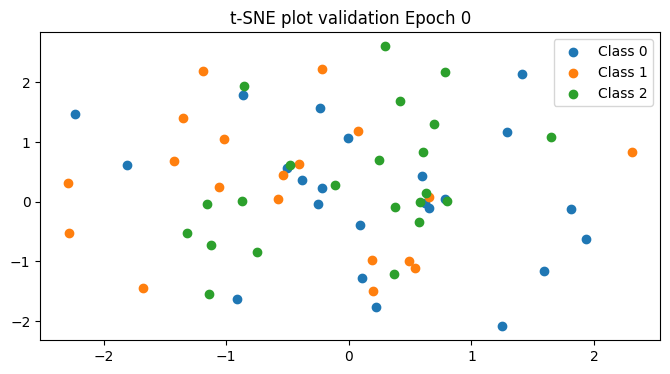

y_true shape: (64,)
y_pred shape: (64,)


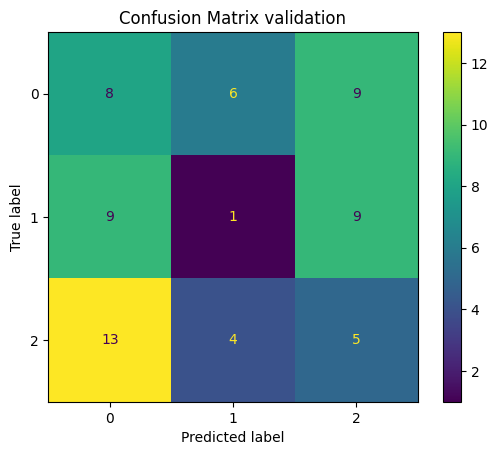

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6698185205459595
target_val/accuracy: 0.7177730202674866
target_val/f1: 0.7177152633666992
source_val/loss: 0.5699754953384399
source_val/accuracy: 0.7603866457939148
source_val/f1: 0.7596486806869507
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


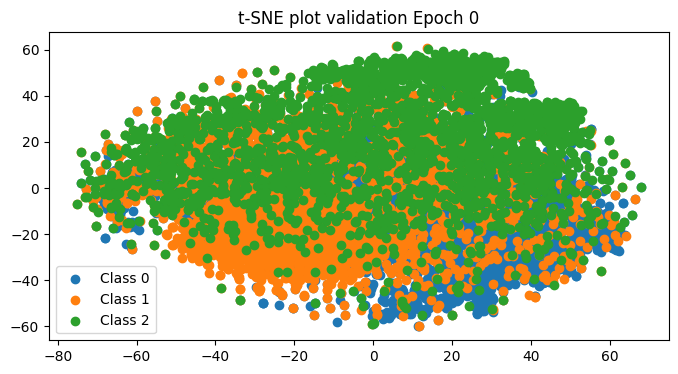

y_true shape: (7735,)
y_pred shape: (7735,)


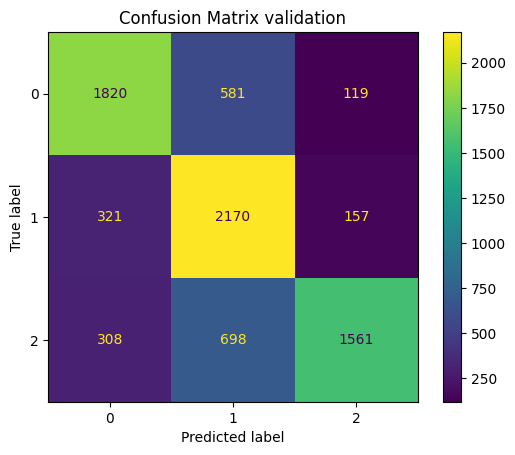

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6038020849227905
target_val/accuracy: 0.7587079405784607
target_val/f1: 0.7579949498176575
source_val/loss: 0.5227943658828735
source_val/accuracy: 0.7926697134971619
source_val/f1: 0.792355477809906
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


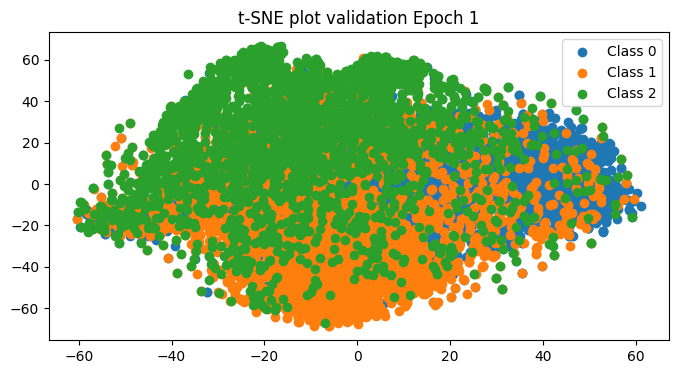

y_true shape: (7735,)
y_pred shape: (7735,)


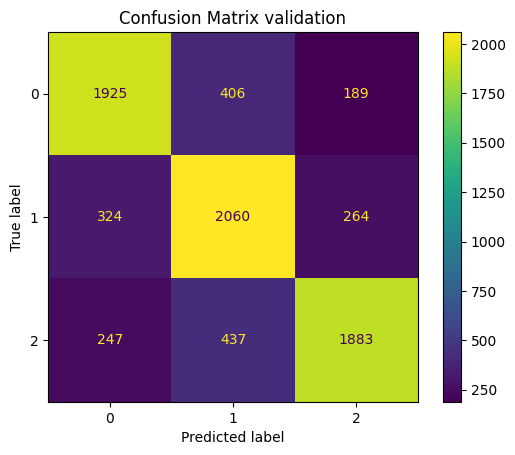

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6737948060035706
target_val/accuracy: 0.7576243877410889
target_val/f1: 0.7567724585533142
source_val/loss: 0.5567426681518555
source_val/accuracy: 0.7946853041648865
source_val/f1: 0.7943321466445923
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


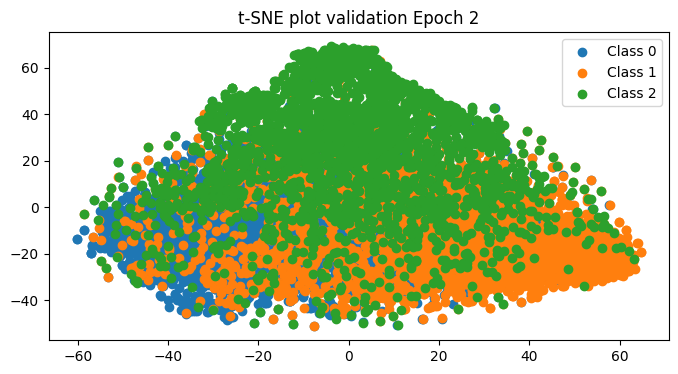

y_true shape: (7735,)
y_pred shape: (7735,)


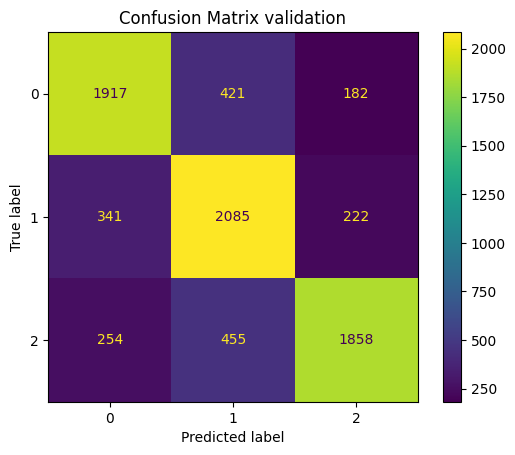

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.736197292804718
target_val/accuracy: 0.7536717653274536
target_val/f1: 0.7529707551002502
source_val/loss: 0.5916933417320251
source_val/accuracy: 0.7924395799636841
source_val/f1: 0.7919245362281799
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


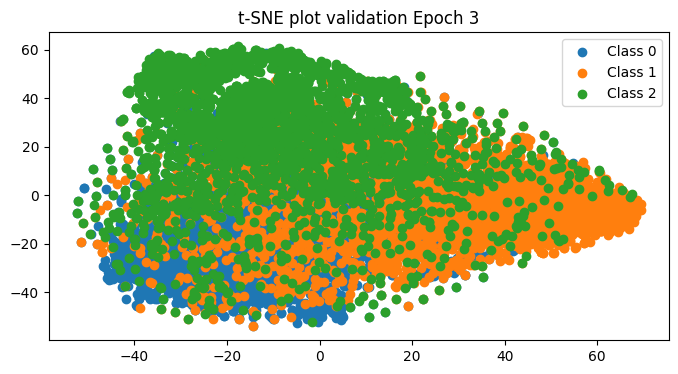

y_true shape: (7735,)
y_pred shape: (7735,)


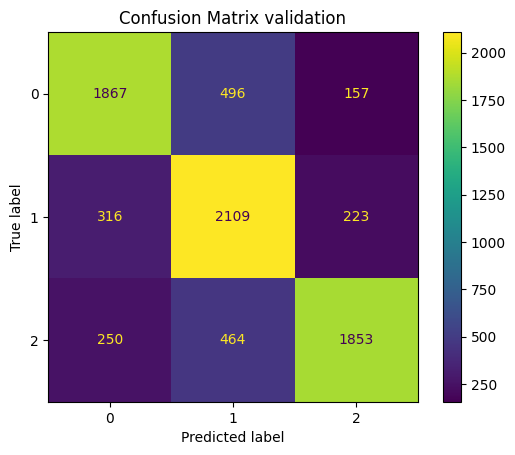

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.8299782276153564
target_val/accuracy: 0.760128378868103
target_val/f1: 0.7597883939743042
source_val/loss: 0.6724238991737366
source_val/accuracy: 0.7948649525642395
source_val/f1: 0.7945577502250671
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


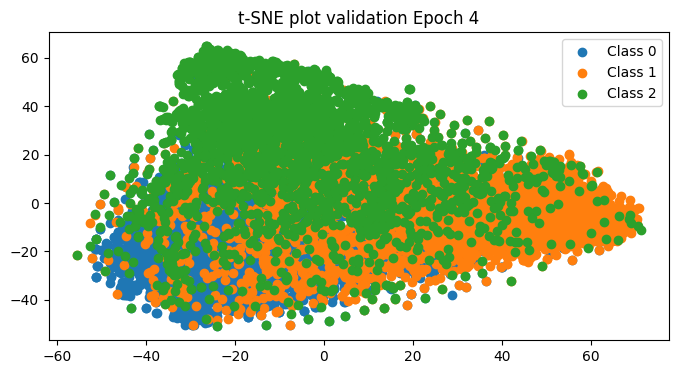

y_true shape: (7735,)
y_pred shape: (7735,)


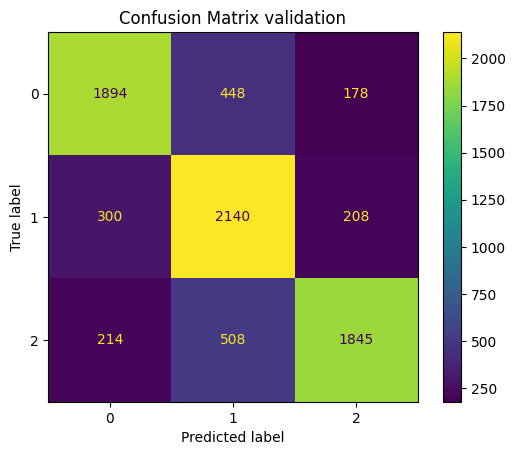

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: checkpoints/lightning_logs/version_1/checkpoints/task-TEF-epoch=01-val_loss=0.52.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_1/checkpoints/TEF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: telephone
print: fiction
print: 69613


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


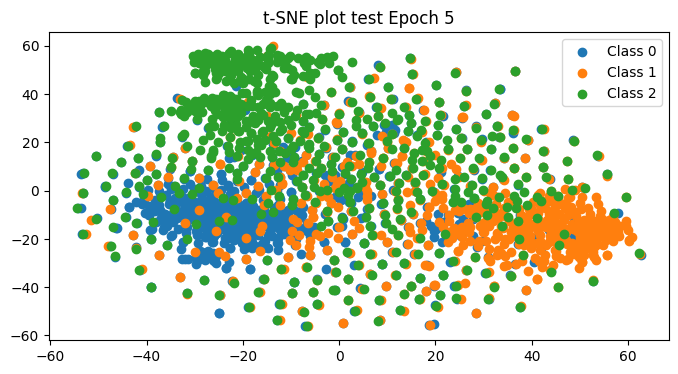

y_true shape: (1966,)
y_pred shape: (1966,)


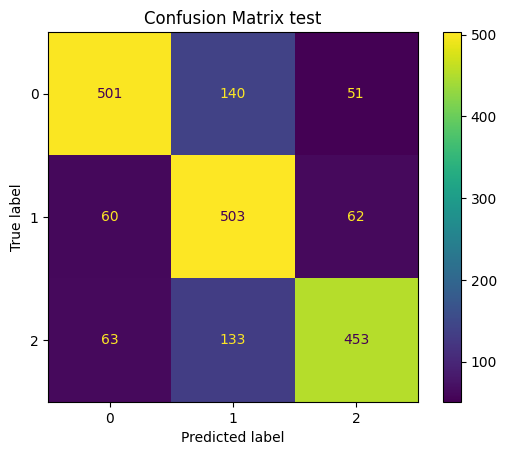

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7955788969993591     │
│      source_test/f1       │    0.7946926951408386     │
│   source_test/f1_macro    │    0.7881176471710205     │
│   source_test/f1_micro    │    0.7955788969993591     │
│     source_test/loss      │    0.7119813561439514     │
│   target_test/accuracy    │     0.740207314491272     │
│      target_test/f1       │    0.7381578087806702     │
│   target_test/f1_macro    │    0.7321584820747375     │
│   target_test/f1_micro    │     0.740207314491272     │
│     target_test/loss      │    0.8935269713401794     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.7119813561439514, 'source_test/accuracy': 0.7955788969993591, 'source_test/f1': 0.7946926951408386, 'source_test/f1_macro': 0.7881176471710205, 'source_test/f1_micro': 0.7955788969993591, 'target_test/loss': 0.8935269713401794, 'target_test/accuracy': 0.740207314491272, 'target_test/f1': 0.7381578087806702, 'target_test/f1_macro': 0.7321584820747375, 'target_test/f1_micro': 0.740207314491272}]
Best checkpoint path: checkpoints/lightning_logs/version_1/checkpoints/task-TEF-epoch=01-val_loss=0.52.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_1/checkpoints/TEF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


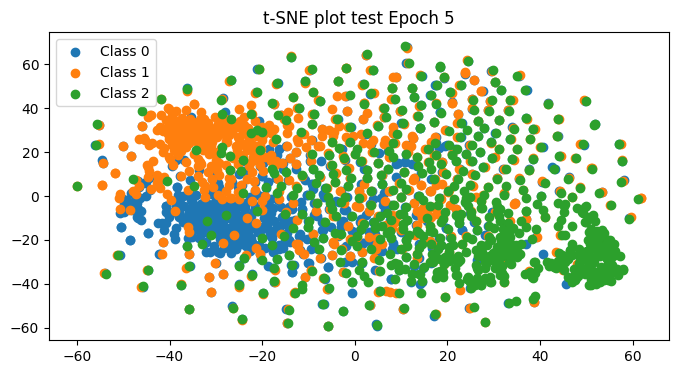

y_true shape: (1966,)
y_pred shape: (1966,)


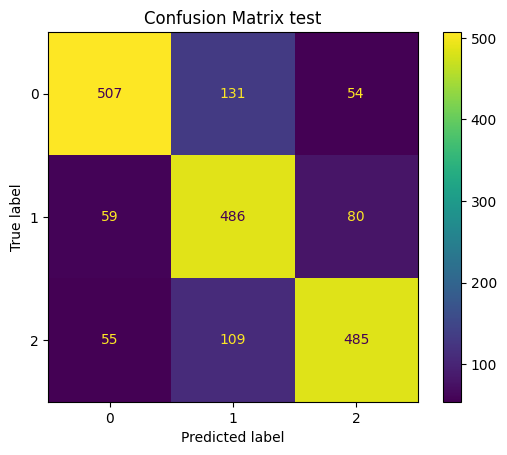

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7900345325469971     │
│      source_test/f1       │    0.7892601490020752     │
│   source_test/f1_macro    │    0.7807576060295105     │
│   source_test/f1_micro    │    0.7900345325469971     │
│     source_test/loss      │    0.5455424189567566     │
│   target_test/accuracy    │    0.7501439452171326     │
│      target_test/f1       │     0.748169481754303     │
│   target_test/f1_macro    │    0.7420855760574341     │
│   target_test/f1_micro    │    0.7501439452171326     │
│     target_test/loss      │    0.6336901187896729     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.5455424189567566, 'source_test/accuracy': 0.7900345325469971, 'source_test/f1': 0.7892601490020752, 'source_test/f1_macro': 0.7807576060295105, 'source_test/f1_micro': 0.7900345325469971, 'target_test/loss': 0.6336901187896729, 'target_test/accuracy': 0.7501439452171326, 'target_test/f1': 0.748169481754303, 'target_test/f1_macro': 0.7420855760574341, 'target_test/f1_micro': 0.7501439452171326}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


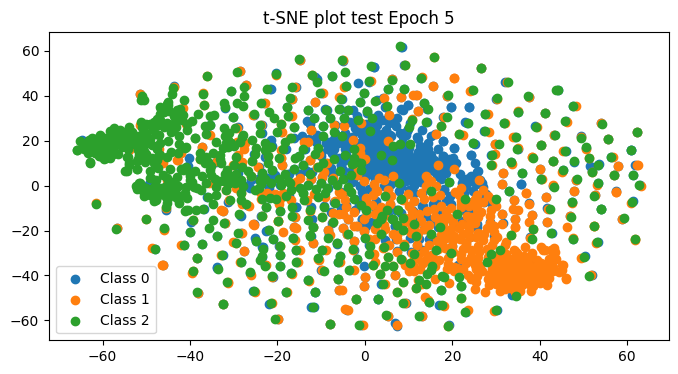

y_true shape: (1966,)
y_pred shape: (1966,)


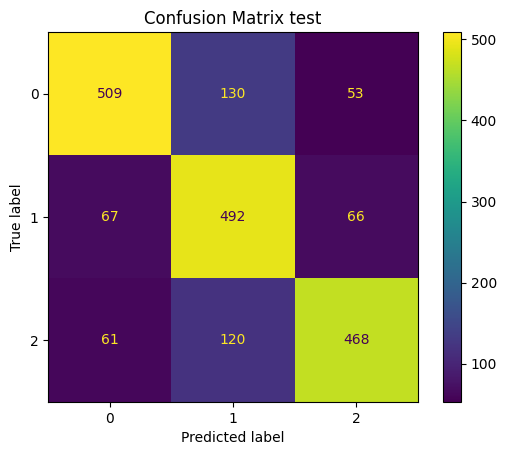

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7940667867660522     │
│      source_test/f1       │    0.7935770153999329     │
│   source_test/f1_macro    │    0.7856731414794922     │
│   source_test/f1_micro    │    0.7940667867660522     │
│     source_test/loss      │    0.5686308145523071     │
│   target_test/accuracy    │    0.7456076741218567     │
│      target_test/f1       │    0.7450425028800964     │
│   target_test/f1_macro    │    0.7361574172973633     │
│   target_test/f1_micro    │    0.7456076741218567     │
│     target_test/loss      │     0.718345582485199     │
└───────────────────────────┴───────────────────────────┘

Test Results on saved epoch: [{'source_test/loss': 0.5686308145523071, 'source_test/accuracy': 0.7940667867660522, 'source_test/f1': 0.7935770153999329, 'source_test/f1_macro': 0.7856731414794922, 'source_test/f1_micro': 0.7940667867660522, 'target_test/loss': 0.718345582485199, 'target_test/accuracy': 0.7456076741218567, 'target_test/f1': 0.7450425028800964, 'target_test/f1_macro': 0.7361574172973633, 'target_test/f1_micro': 0.7456076741218567}]


In [8]:
for seed in seeds:
    #wandb.init(project=project_name, name=f'{domain}_{type}_run_with_seed_{seed}', config={'seed': seed})

    try:
        seed_everything(seed)

        hparams = {
            "source_target": "telephone_fiction",
            "source_domain": "telephone",
            "target_domain": "fiction",
            "domain_adapter_name": "mlm_union_F",
            "task_adapter_name": "task_TEF",
            "pretrained_model_name": "bert-base-uncased",
            "padding": "max_length",
            "max_seq_length": 128,
            "bsz": 32,
            "num_classes": 3,
            "learning_rate": 1e-4,
            "reduction_factor": 16,
            "mode": "domain",
            "saved_adapter_dir": "../../saved/adapters",
        }

        save_dir = "checkpoints"
        save_epoch_3 = 3  # Save model at the 3rd epoch
        #save_model_callback_epoch = SaveModelAtEpochCallback(save_dir, save_epoch_3)
        # Add a print statement to confirm the callback initialization
        #print(f"Initialized SaveModelAtEpochCallback with save_dir={save_dir} and save_epoch={save_epoch_3}")
        dm = processed.DataModuleSourceTarget(hparams)
        dm.setup('fit')
        dm.setup("test")

        model = DomainTaskAdapter(hparams)

        checkpoint_callback = ModelCheckpoint(
            filename="task-TEF-{epoch:02d}-{val_loss:.2f}",
            save_top_k=1,
            monitor="val_loss",
            mode="min",
        )
        save_model_callback_epoch = ModelCheckpoint(
                # dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
                filename="TEF-{epoch:02d}",
                every_n_epochs=save_epoch_3,
                save_top_k=-1,  # <--- this is important!
            )
       
        #wandb_logger = WandbLogger()
        
    except Exception as e:
        print(f"Error during preprocessing : {e}")   

    try:
        train_loader = dm.train_dataloader()
        val_loader = dm.val_dataloader()
        trainer = Trainer(
            max_epochs=5,
            accelerator="auto",
            default_root_dir="checkpoints",
            # precision=16,
            #logger=wandb_logger,
            callbacks=[checkpoint_callback,save_model_callback_epoch],
            limit_train_batches=1.0,
            limit_val_batches=1.0,
            limit_test_batches=1.0,
            # log_every_n_TESps=10,
        )
      
        trainer.fit(model, train_loader, val_loader)
           # ATESr training, print the paths to verify
        print(f"Best checkpoint path: {checkpoint_callback.best_model_path}")
        print(f"Saved epoch checkpoint path: {save_model_callback_epoch.best_model_path}")
    except Exception as e:
        print(f"Error during training : {e}")

    try:
        
        dm.setup("test")
        test_loader = dm.test_dataloader()
        test_results_last = trainer.test(model, test_loader)
        print("Test Results Last Epoch:", test_results_last)

        # Collect results for last epoch model
        for key, value in test_results_last[0].items():
            results["last_epoch"][key].append(value)

        # Paths to the saved checkpoints
        best_checkpoint_path = checkpoint_callback.best_model_path
        saved_epoch_checkpoint_path = save_model_callback_epoch.best_model_path
        # Print the paths to verify
        print(f"Best checkpoint path: {best_checkpoint_path}")
        print(f"Saved epoch checkpoint path: {saved_epoch_checkpoint_path}")
        
        best_model = DomainTaskAdapter.load_from_checkpoint(best_checkpoint_path)
        test_results_best = trainer.test(best_model, test_loader)
        print("Test Results on Best Model:", test_results_best)
        # Collect results for best model
        for key, value in test_results_best[0].items():
            results["best_model"][key].append(value)

        saved_epoch_model = DomainTaskAdapter.load_from_checkpoint(saved_epoch_checkpoint_path)
        test_results_saved_epoch = trainer.test(saved_epoch_model, test_loader)
        print("Test Results on saved epoch:", test_results_saved_epoch)
        # Collect results for 3rd epoch model
        for key, value in test_results_saved_epoch[0].items():
            results["epoch_saved"][key].append(value)
        

    except Exception as e:
        print(f"Error during testing: {e}")

    # Finish the wandb run
    #wandb.finish()

Seed set to 42
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: telephone
print: fiction
print: 69613
prinssst: telephone
print: fiction
print: 69613


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configu

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | BertAdapterModel   | 118 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
3 | f1        | MulticlassF1Score  | 0     
4 | f1_macro  | MulticlassF1Score  | 0     
5 | f1_micro  | MulticlassF1Score  | 0     
6 | softmax   | Softmax            | 0     
-------------------------------------------------
8.9 M     Trainable params
109 M     Non-trainable params
118 M     Total params
473.522   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.1080307960510254
target_val/accuracy: 0.34375
target_val/f1: 0.4390262961387634
source_val/loss: 1.1139590740203857
source_val/accuracy: 0.25
source_val/f1: 0.31409552693367004
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


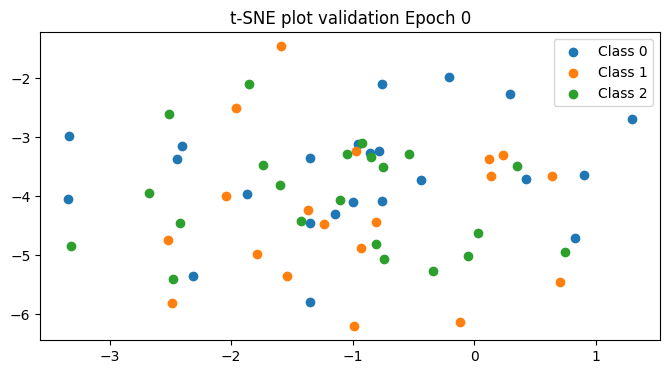

y_true shape: (64,)
y_pred shape: (64,)


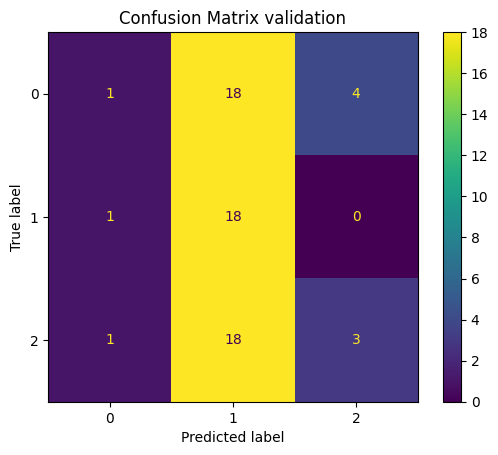

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6723847389221191
target_val/accuracy: 0.720434308052063
target_val/f1: 0.7216405868530273
source_val/loss: 0.5762272477149963
source_val/accuracy: 0.7644683718681335
source_val/f1: 0.7642213106155396
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


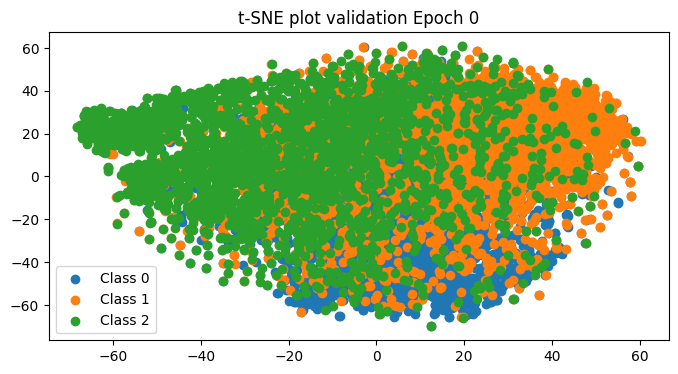

y_true shape: (7735,)
y_pred shape: (7735,)


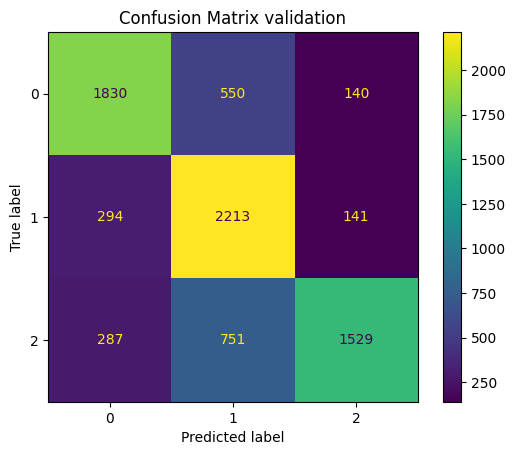

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6179019808769226
target_val/accuracy: 0.754833996295929
target_val/f1: 0.7539172768592834
source_val/loss: 0.534638524055481
source_val/accuracy: 0.782934308052063
source_val/f1: 0.7818632125854492
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


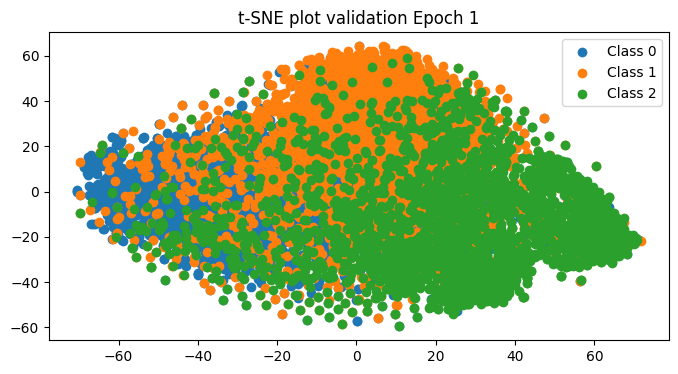

y_true shape: (7735,)
y_pred shape: (7735,)


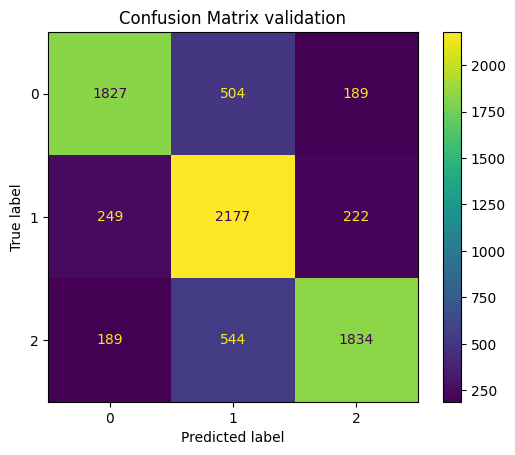

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6373865008354187
target_val/accuracy: 0.7658888697624207
target_val/f1: 0.7651649117469788
source_val/loss: 0.5569350123405457
source_val/accuracy: 0.7892617583274841
source_val/f1: 0.7886794209480286
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


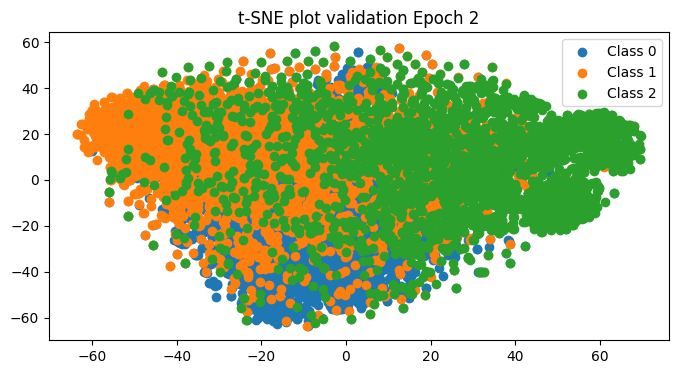

y_true shape: (7735,)
y_pred shape: (7735,)


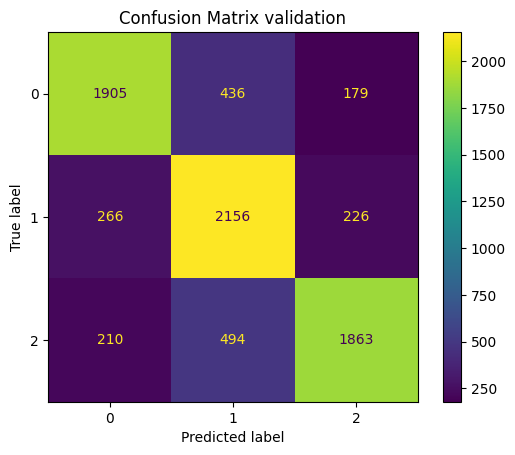

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7043853998184204
target_val/accuracy: 0.762660562992096
target_val/f1: 0.7621715664863586
source_val/loss: 0.592551052570343
source_val/accuracy: 0.7873528599739075
source_val/f1: 0.7864633202552795
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


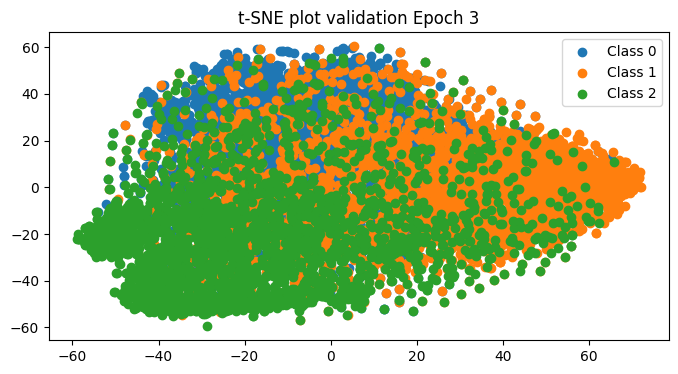

y_true shape: (7735,)
y_pred shape: (7735,)


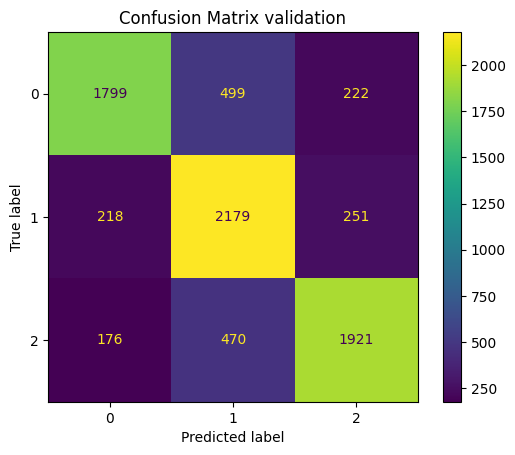

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7797751426696777
target_val/accuracy: 0.7565913200378418
target_val/f1: 0.7561814785003662
source_val/loss: 0.6508293151855469
source_val/accuracy: 0.7861120700836182
source_val/f1: 0.7854030132293701
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


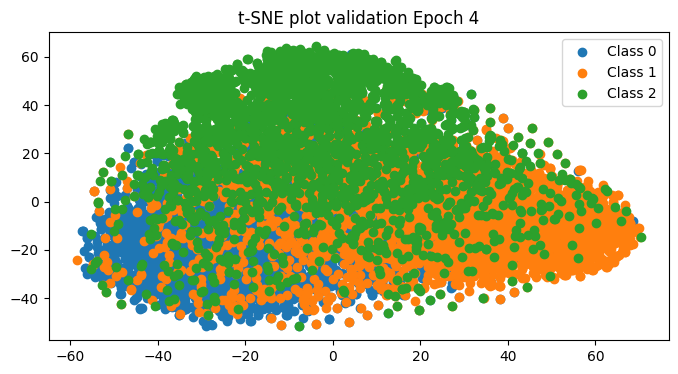

y_true shape: (7735,)
y_pred shape: (7735,)


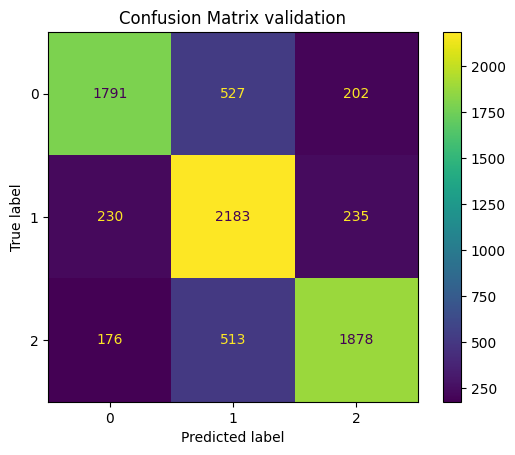

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: ./lightning_logs/kh8b9lcz/checkpoints/task-TEF-epoch=01-val_loss=0.53.ckpt
Saved epoch checkpoint path: ./lightning_logs/kh8b9lcz/checkpoints/TEF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: telephone
print: fiction
print: 69613


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


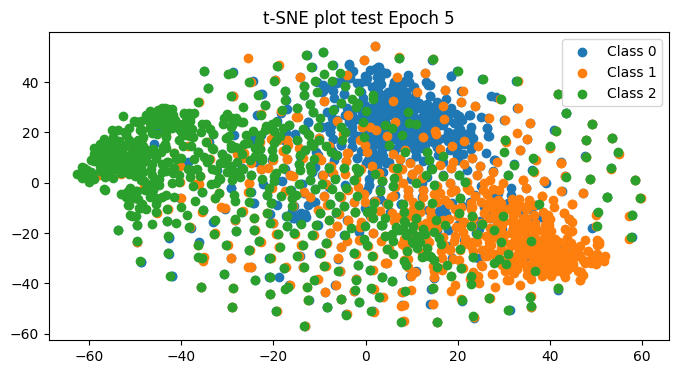

y_true shape: (1966,)
y_pred shape: (1966,)


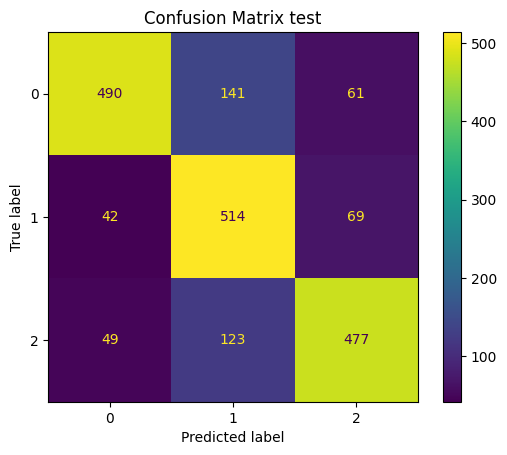

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7937068343162537     │
│      source_test/f1       │    0.7921852469444275     │
│   source_test/f1_macro    │    0.7860733270645142     │
│   source_test/f1_micro    │    0.7937068343162537     │
│     source_test/loss      │    0.7033971548080444     │
│   target_test/accuracy    │    0.7529521584510803     │
│      target_test/f1       │    0.7521251440048218     │
│   target_test/f1_macro    │    0.7440399527549744     │
│   target_test/f1_micro    │    0.7529521584510803     │
│     target_test/loss      │    0.8175301551818848     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.7033971548080444, 'source_test/accuracy': 0.7937068343162537, 'source_test/f1': 0.7921852469444275, 'source_test/f1_macro': 0.7860733270645142, 'source_test/f1_micro': 0.7937068343162537, 'target_test/loss': 0.8175301551818848, 'target_test/accuracy': 0.7529521584510803, 'target_test/f1': 0.7521251440048218, 'target_test/f1_macro': 0.7440399527549744, 'target_test/f1_micro': 0.7529521584510803}]
Best checkpoint path: ./lightning_logs/kh8b9lcz/checkpoints/task-TEF-epoch=01-val_loss=0.53.ckpt
Saved epoch checkpoint path: ./lightning_logs/kh8b9lcz/checkpoints/TEF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


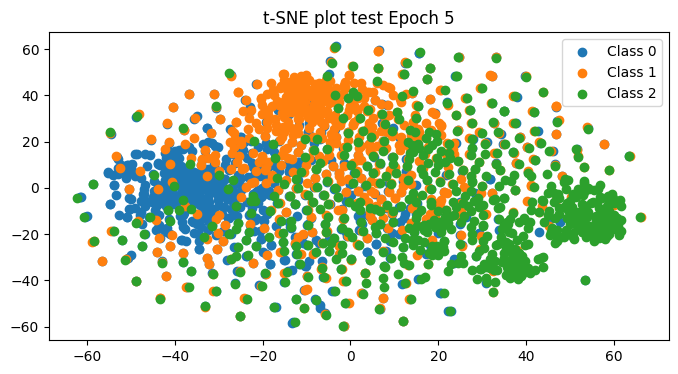

y_true shape: (1966,)
y_pred shape: (1966,)


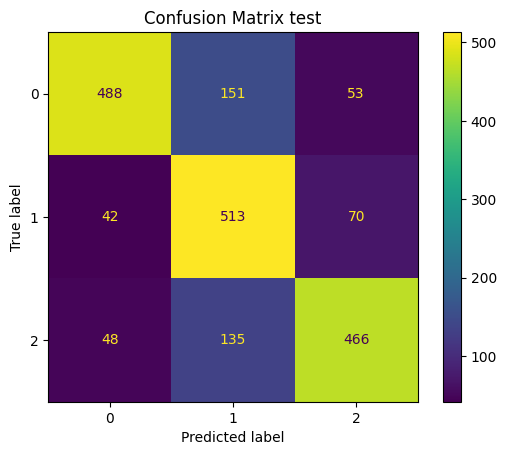

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7875143885612488     │
│      source_test/f1       │    0.7863202691078186     │
│   source_test/f1_macro    │    0.7793418765068054     │
│   source_test/f1_micro    │    0.7875143885612488     │
│     source_test/loss      │    0.5524843335151672     │
│   target_test/accuracy    │    0.7465437650680542     │
│      target_test/f1       │    0.7448190450668335     │
│   target_test/f1_macro    │    0.7374310493469238     │
│   target_test/f1_micro    │    0.7465437650680542     │
│     target_test/loss      │    0.6500638723373413     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.5524843335151672, 'source_test/accuracy': 0.7875143885612488, 'source_test/f1': 0.7863202691078186, 'source_test/f1_macro': 0.7793418765068054, 'source_test/f1_micro': 0.7875143885612488, 'target_test/loss': 0.6500638723373413, 'target_test/accuracy': 0.7465437650680542, 'target_test/f1': 0.7448190450668335, 'target_test/f1_macro': 0.7374310493469238, 'target_test/f1_micro': 0.7465437650680542}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


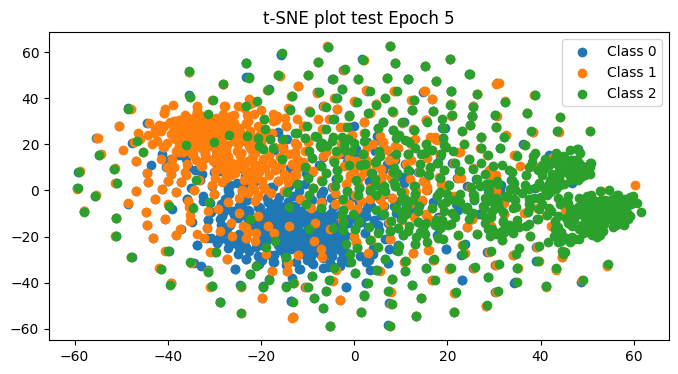

y_true shape: (1966,)
y_pred shape: (1966,)


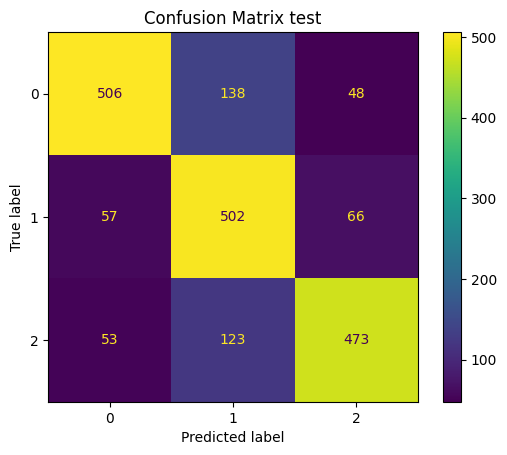

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7949308156967163     │
│      source_test/f1       │    0.7935240864753723     │
│   source_test/f1_macro    │    0.7876302003860474     │
│   source_test/f1_micro    │    0.7949308156967163     │
│     source_test/loss      │    0.5756274461746216     │
│   target_test/accuracy    │    0.7529521584510803     │
│      target_test/f1       │    0.7515211701393127     │
│   target_test/f1_macro    │    0.7432908415794373     │
│   target_test/f1_micro    │    0.7529521584510803     │
│     target_test/loss      │    0.6718122959136963     │
└───────────────────────────┴───────────────────────────┘

Test Results on saved epoch: [{'source_test/loss': 0.5756274461746216, 'source_test/accuracy': 0.7949308156967163, 'source_test/f1': 0.7935240864753723, 'source_test/f1_macro': 0.7876302003860474, 'source_test/f1_micro': 0.7949308156967163, 'target_test/loss': 0.6718122959136963, 'target_test/accuracy': 0.7529521584510803, 'target_test/f1': 0.7515211701393127, 'target_test/f1_macro': 0.7432908415794373, 'target_test/f1_micro': 0.7529521584510803}]


epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█
source_test/accuracy,▇▁█
source_test/f1,▇▁█
source_test/f1_macro,▇▁█
source_test/f1_micro,▇▁█
source_test/loss,█▁▂
source_val/accuracy,▁▆█▇▇
source_val/f1,▁▆█▇▇
source_val/loss,▄▁▂▄█
target_test/accuracy,█▁█
target_test/f1,█▁▇


Seed set to 10
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: telephone
print: fiction
print: 69613
prinssst: telephone
print: fiction
print: 69613


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/home/guest/.cache/pypoetry/virtualenvs

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.112105131149292
target_val/accuracy: 0.265625
target_val/f1: 0.35850805044174194
source_val/loss: 1.1086190938949585
source_val/accuracy: 0.34375
source_val/f1: 0.4455302357673645
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


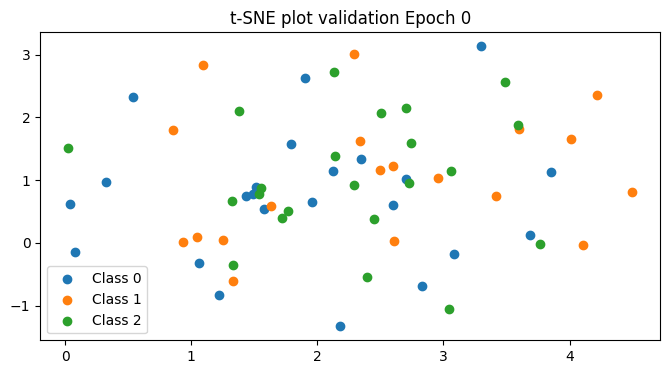

y_true shape: (64,)
y_pred shape: (64,)


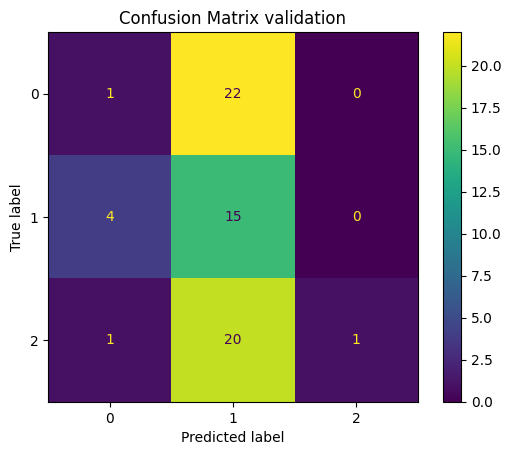

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6696172952651978
target_val/accuracy: 0.7184187173843384
target_val/f1: 0.7179282903671265
source_val/loss: 0.5734913945198059
source_val/accuracy: 0.7663267254829407
source_val/f1: 0.7657185792922974
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


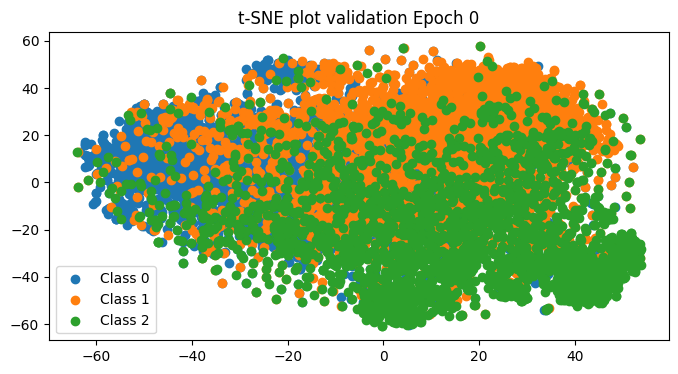

y_true shape: (7735,)
y_pred shape: (7735,)


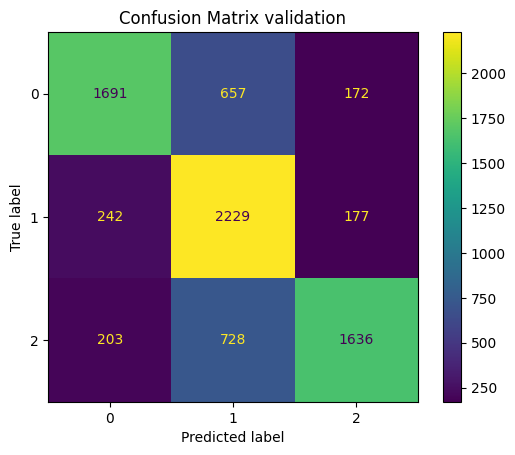

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6447980403900146
target_val/accuracy: 0.7432907223701477
target_val/f1: 0.7428802847862244
source_val/loss: 0.5456972718238831
source_val/accuracy: 0.7866791486740112
source_val/f1: 0.7860835790634155
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


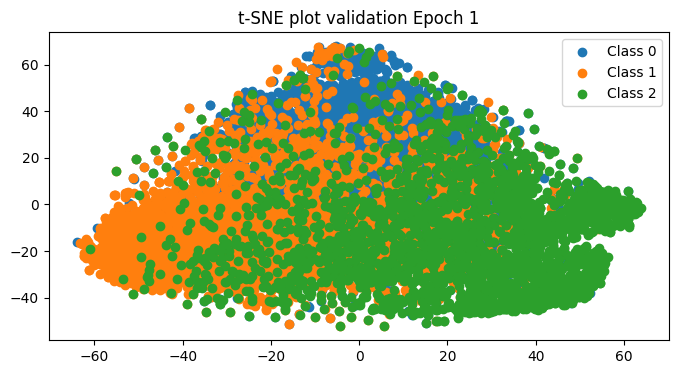

y_true shape: (7735,)
y_pred shape: (7735,)


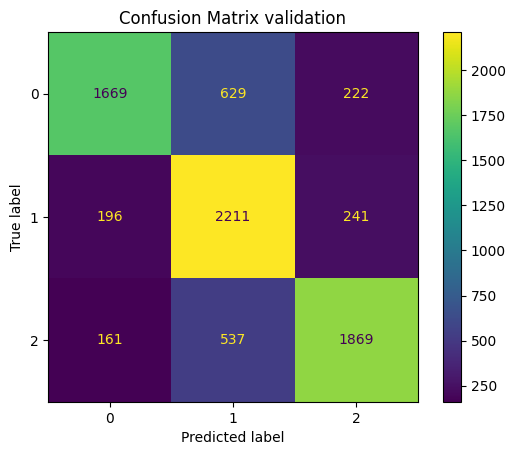

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6372367739677429
target_val/accuracy: 0.7649062871932983
target_val/f1: 0.7637761235237122
source_val/loss: 0.5425792932510376
source_val/accuracy: 0.7935736179351807
source_val/f1: 0.7928423881530762
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


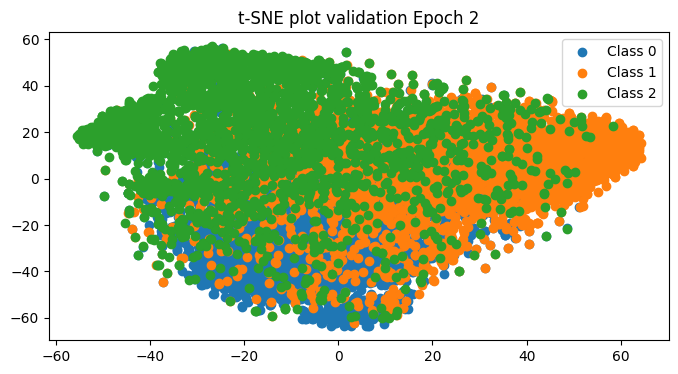

y_true shape: (7735,)
y_pred shape: (7735,)


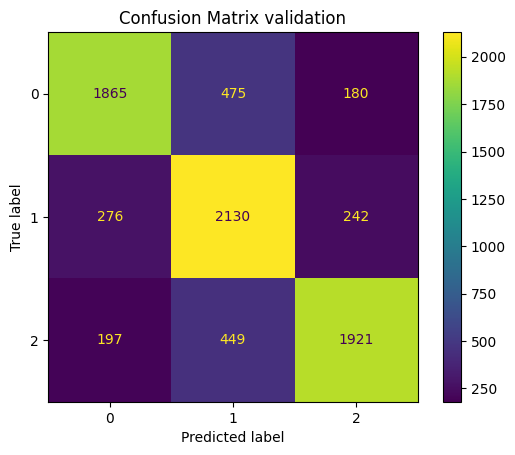

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7476503849029541
target_val/accuracy: 0.7547048330307007
target_val/f1: 0.7539315223693848
source_val/loss: 0.6146644949913025
source_val/accuracy: 0.7870665192604065
source_val/f1: 0.7858337759971619
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


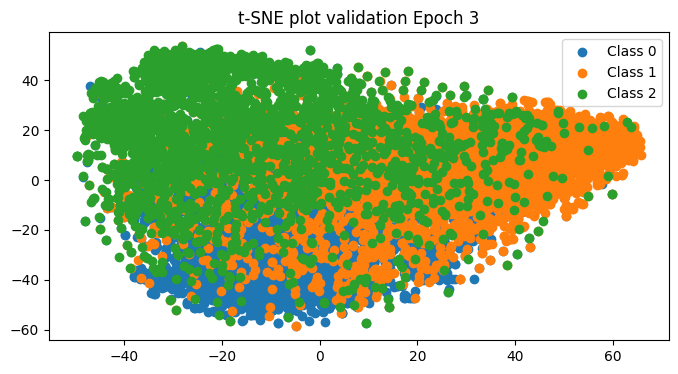

y_true shape: (7735,)
y_pred shape: (7735,)


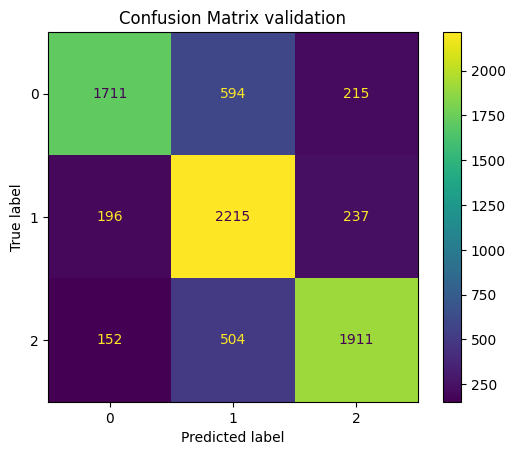

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.7426612377166748
target_val/accuracy: 0.7688589096069336
target_val/f1: 0.7680466771125793
source_val/loss: 0.6292339563369751
source_val/accuracy: 0.7967009544372559
source_val/f1: 0.7972279787063599
Features shape: (7735, 128, 768)
Labels shape: (7735,)
Flattened features shape: (7735, 98304)


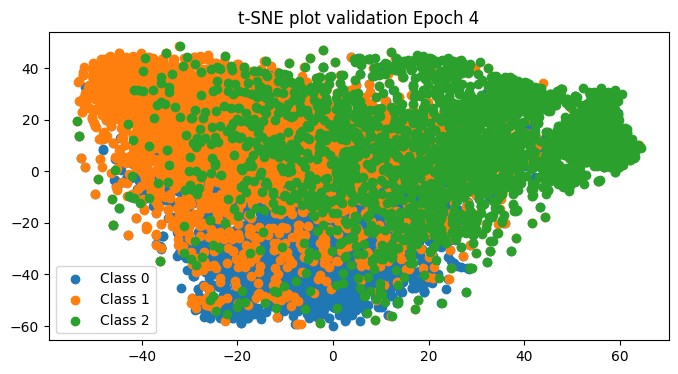

y_true shape: (7735,)
y_pred shape: (7735,)


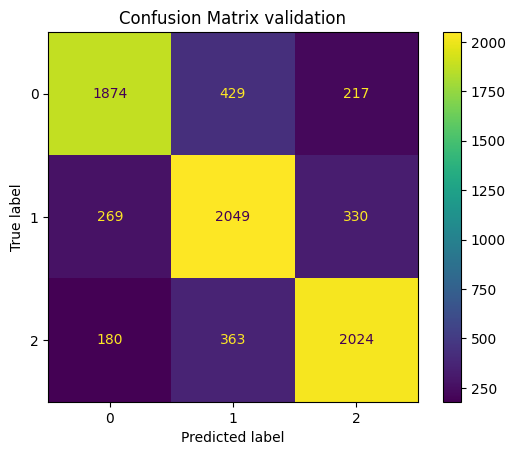

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: ./lightning_logs/85i34vhc/checkpoints/task-TEF-epoch=02-val_loss=0.54.ckpt
Saved epoch checkpoint path: ./lightning_logs/85i34vhc/checkpoints/TEF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: telephone
print: fiction
print: 69613


Testing: |          | 0/? [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


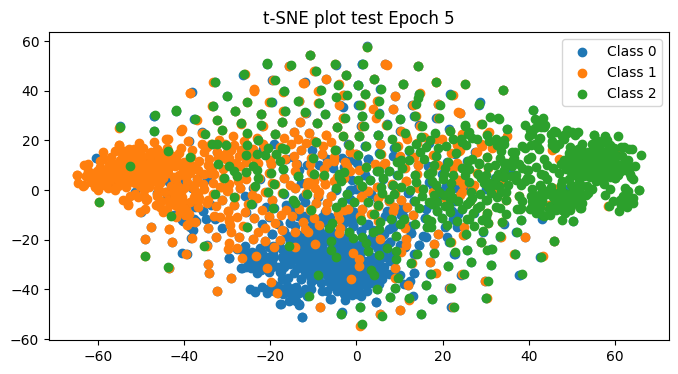

y_true shape: (1966,)
y_pred shape: (1966,)


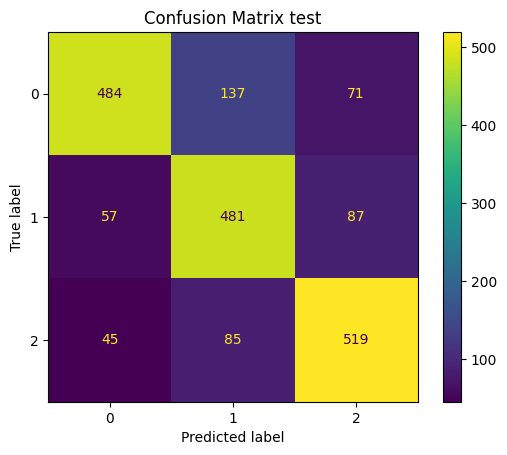

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7916907072067261     │
│      source_test/f1       │    0.7925539016723633     │
│   source_test/f1_macro    │    0.7812326550483704     │
│   source_test/f1_micro    │    0.7916907072067261     │
│     source_test/loss      │    0.7000558376312256     │
│   target_test/accuracy    │    0.7551122903823853     │
│      target_test/f1       │    0.7546103596687317     │
│   target_test/f1_macro    │    0.7457221746444702     │
│   target_test/f1_micro    │    0.7551122903823853     │
│     target_test/loss      │    0.7888429760932922     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.7000558376312256, 'source_test/accuracy': 0.7916907072067261, 'source_test/f1': 0.7925539016723633, 'source_test/f1_macro': 0.7812326550483704, 'source_test/f1_micro': 0.7916907072067261, 'target_test/loss': 0.7888429760932922, 'target_test/accuracy': 0.7551122903823853, 'target_test/f1': 0.7546103596687317, 'target_test/f1_macro': 0.7457221746444702, 'target_test/f1_micro': 0.7551122903823853}]
Best checkpoint path: ./lightning_logs/85i34vhc/checkpoints/task-TEF-epoch=02-val_loss=0.54.ckpt
Saved epoch checkpoint path: ./lightning_logs/85i34vhc/checkpoints/TEF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


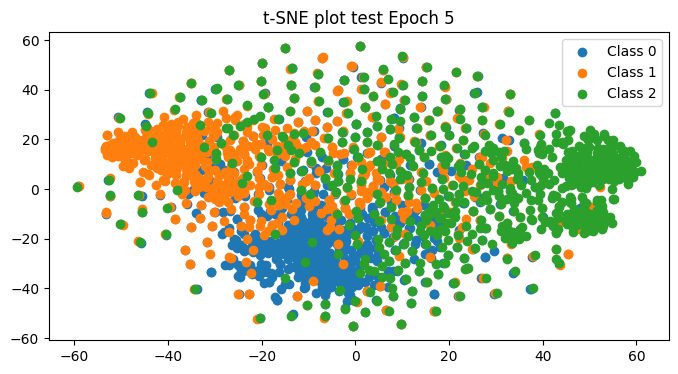

y_true shape: (1966,)
y_pred shape: (1966,)


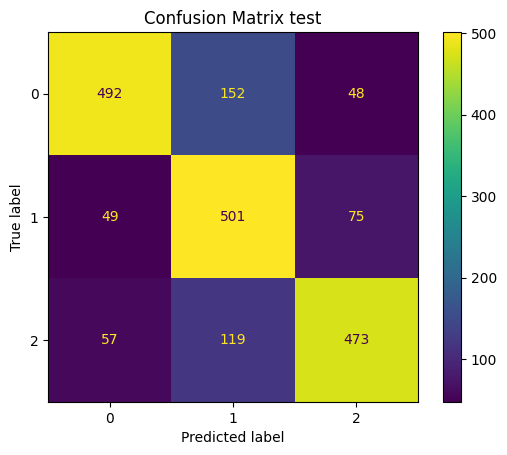

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7955788969993591     │
│      source_test/f1       │    0.7944300770759583     │
│   source_test/f1_macro    │     0.785472571849823     │
│   source_test/f1_micro    │    0.7955788969993591     │
│     source_test/loss      │    0.5577028393745422     │
│   target_test/accuracy    │    0.7453917264938354     │
│      target_test/f1       │    0.7446174621582031     │
│   target_test/f1_macro    │    0.7359555959701538     │
│   target_test/f1_micro    │    0.7453917264938354     │
│     target_test/loss      │    0.6845344305038452     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.5577028393745422, 'source_test/accuracy': 0.7955788969993591, 'source_test/f1': 0.7944300770759583, 'source_test/f1_macro': 0.785472571849823, 'source_test/f1_micro': 0.7955788969993591, 'target_test/loss': 0.6845344305038452, 'target_test/accuracy': 0.7453917264938354, 'target_test/f1': 0.7446174621582031, 'target_test/f1_macro': 0.7359555959701538, 'target_test/f1_micro': 0.7453917264938354}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1966, 128, 768)
Labels shape: (1966,)
Flattened features shape: (1966, 98304)


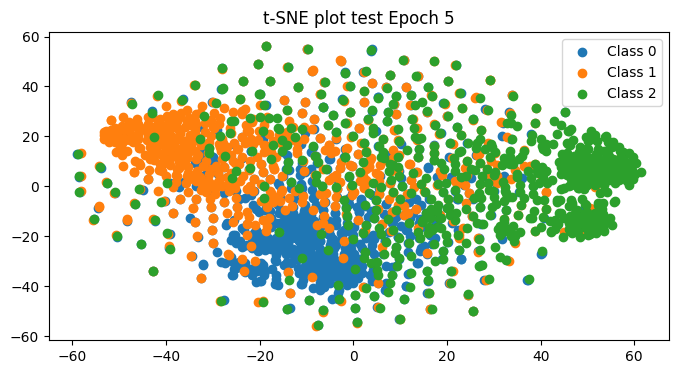

y_true shape: (1966,)
y_pred shape: (1966,)


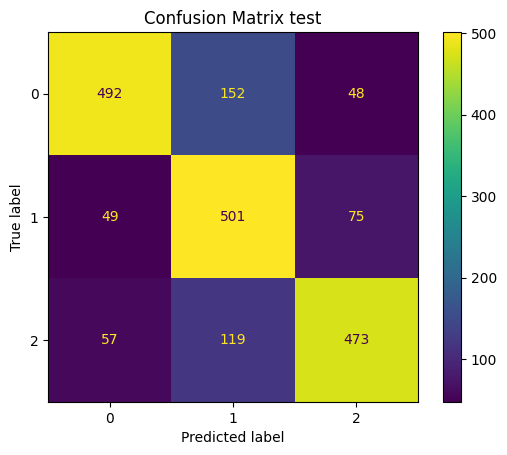

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7955788969993591     │
│      source_test/f1       │    0.7944300770759583     │
│   source_test/f1_macro    │     0.785472571849823     │
│   source_test/f1_micro    │    0.7955788969993591     │
│     source_test/loss      │    0.5577028393745422     │
│   target_test/accuracy    │    0.7453917264938354     │
│      target_test/f1       │    0.7446174621582031     │
│   target_test/f1_macro    │    0.7359555959701538     │
│   target_test/f1_micro    │    0.7453917264938354     │
│     target_test/loss      │    0.6845344305038452     │
└───────────────────────────┴───────────────────────────┘

Test Results on saved epoch: [{'source_test/loss': 0.5577028393745422, 'source_test/accuracy': 0.7955788969993591, 'source_test/f1': 0.7944300770759583, 'source_test/f1_macro': 0.785472571849823, 'source_test/f1_micro': 0.7955788969993591, 'target_test/loss': 0.6845344305038452, 'target_test/accuracy': 0.7453917264938354, 'target_test/f1': 0.7446174621582031, 'target_test/f1_macro': 0.7359555959701538, 'target_test/f1_micro': 0.7453917264938354}]


wandb: ERROR Control-C detected -- Run data was not synced


In [7]:
for seed in seeds:
    wandb.init(project=project_name, name=f'{domain}_{type}_run_with_seed_{seed}', config={'seed': seed})

    try:
        seed_everything(seed)

        hparams = {
            "source_target": "telephone_fiction",
            "source_domain": "telephone",
            "target_domain": "fiction",
            "domain_adapter_name": "mlm_union_F",
            "task_adapter_name": "task_TEF",
            "pretrained_model_name": "bert-base-uncased",
            "padding": "max_length",
            "max_seq_length": 128,
            "bsz": 32,
            "num_classes": 3,
            "learning_rate": 1e-4,
            "reduction_factor": 16,
            "mode": "domain",
            "saved_adapter_dir": "../../saved/adapters",
        }

        save_dir = "checkpoints"
        save_epoch_3 = 3  # Save model at the 3rd epoch
        #save_model_callback_epoch = SaveModelAtEpochCallback(save_dir, save_epoch_3)
        # Add a print statement to confirm the callback initialization
        #print(f"Initialized SaveModelAtEpochCallback with save_dir={save_dir} and save_epoch={save_epoch_3}")
        dm = processed.DataModuleSourceTarget(hparams)
        dm.setup('fit')
        dm.setup("test")

        model = DomainTaskAdapter(hparams)

        checkpoint_callback = ModelCheckpoint(
            filename="task-TEF-{epoch:02d}-{val_loss:.2f}",
            save_top_k=1,
            monitor="val_loss",
            mode="min",
        )
        save_model_callback_epoch = ModelCheckpoint(
                # dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
                filename="TEF-{epoch:02d}",
                every_n_epochs=save_epoch_3,
                save_top_k=-1,  # <--- this is important!
            )
       
        wandb_logger = WandbLogger()
        
    except Exception as e:
        print(f"Error during preprocessing : {e}")   

    try:
        train_loader = dm.train_dataloader()
        val_loader = dm.val_dataloader()
        trainer = Trainer(
            max_epochs=5,
            accelerator="auto",
            default_root_dir="checkpoints",
            # precision=16,
            logger=wandb_logger,
            callbacks=[checkpoint_callback,save_model_callback_epoch],
            limit_train_batches=1.0,
            limit_val_batches=1.0,
            limit_test_batches=1.0,
            # log_every_n_TESps=10,
        )
      
        trainer.fit(model, train_loader, val_loader)
           # ATESr training, print the paths to verify
        print(f"Best checkpoint path: {checkpoint_callback.best_model_path}")
        print(f"Saved epoch checkpoint path: {save_model_callback_epoch.best_model_path}")
    except Exception as e:
        print(f"Error during training : {e}")

    try:
        
        dm.setup("test")
        test_loader = dm.test_dataloader()
        test_results_last = trainer.test(model, test_loader)
        print("Test Results Last Epoch:", test_results_last)

        # Collect results for last epoch model
        for key, value in test_results_last[0].items():
            results["last_epoch"][key].append(value)

        # Paths to the saved checkpoints
        best_checkpoint_path = checkpoint_callback.best_model_path
        saved_epoch_checkpoint_path = save_model_callback_epoch.best_model_path
        # Print the paths to verify
        print(f"Best checkpoint path: {best_checkpoint_path}")
        print(f"Saved epoch checkpoint path: {saved_epoch_checkpoint_path}")
        
        best_model = DomainTaskAdapter.load_from_checkpoint(best_checkpoint_path)
        test_results_best = trainer.test(best_model, test_loader)
        print("Test Results on Best Model:", test_results_best)
        # Collect results for best model
        for key, value in test_results_best[0].items():
            results["best_model"][key].append(value)

        saved_epoch_model = DomainTaskAdapter.load_from_checkpoint(saved_epoch_checkpoint_path)
        test_results_saved_epoch = trainer.test(saved_epoch_model, test_loader)
        print("Test Results on saved epoch:", test_results_saved_epoch)
        # Collect results for 3rd epoch model
        for key, value in test_results_saved_epoch[0].items():
            results["epoch_saved"][key].append(value)
        

    except Exception as e:
        print(f"Error during testing: {e}")

    # Finish the wandb run
    wandb.finish()

In [ ]:
results.items()

dict_items([('last_epoch', {'source_test/loss': [1.1568087339401245, 1.3099210262298584, 1.4747544527053833], 'source_test/accuracy': [0.5, 0.5, 0.625], 'source_test/f1': [0.500230073928833, 0.4842284619808197, 0.6224680542945862], 'source_test/f1_macro': [0.4709761440753937, 0.48479682207107544, 0.603166937828064], 'source_test/f1_micro': [0.5, 0.5, 0.625], 'target_test/loss': [1.070512294769287, 1.2306946516036987, 1.4157129526138306], 'target_test/accuracy': [0.53125, 0.40625, 0.53125], 'target_test/f1': [0.5487637519836426, 0.4055190682411194, 0.5302377343177795], 'target_test/f1_macro': [0.4194139242172241, 0.363716721534729, 0.49956458806991577], 'target_test/f1_micro': [0.53125, 0.40625, 0.53125]}), ('best_model', {'source_test/loss': [1.1568087339401245, 1.3099210262298584, 1.1537240743637085], 'source_test/accuracy': [0.5, 0.5, 0.53125], 'source_test/f1': [0.500230073928833, 0.4842284619808197, 0.5876976251602173], 'source_test/f1_macro': [0.4709761440753937, 0.484796822071075

| Scenario   | Metric                   | Mean     | Std      |
|------------|--------------------------|----------|----------|
| Saved Epoch| Source Test Accuracy     | 0.79453  | 0.00078  |
|            | Source Test F1           | 0.79384  | 0.00038  |
|            | Source Test F1 Macro     | 0.78626  | 0.00084  |
|            | Source Test F1 Micro     | 0.79453  | 0.00078  |
|            | Target Test Accuracy     | 0.74798  | 0.00329  |
|            | Target Test F1           | 0.74773  | 0.00318  |
|            | Target Test F1 Macro     | 0.73880  | 0.00362  |
|            | Target Test F1 Micro     | 0.74798  | 0.00329  |
| Best Model | Source Test Accuracy     | 0.79038  | 0.00394  |
|            | Source Test F1           | 0.78934  | 0.00389  |
|            | Source Test F1 Macro     | 0.78119  | 0.00237  |
|            | Source Test F1 Micro     | 0.79038  | 0.00394  |
|            | Target Test Accuracy     | 0.74736  | 0.00237  |
|            | Target Test F1           | 0.74587  | 0.00238  |
|            | Target Test F1 Macro     | 0.73849  | 0.00257  |
|            | Target Test F1 Micro     | 0.74736  | 0.00237  |
| Last Epoch | Source Test Accuracy     | 0.79366  | 0.00178  |
|            | Source Test F1           | 0.79381  | 0.00110  |
|            | Source Test F1 Macro     | 0.78581  | 0.00289  |
|            | Source Test F1 Micro     | 0.79366  | 0.00178  |
|            | Target Test Accuracy     | 0.74942  | 0.00662  |
|            | Target Test F1           | 0.74830  | 0.00757  |
|            | Target Test F1 Macro     | 0.74064  | 0.00640  |
|            | Target Test F1 Micro     | 0.74942  | 0.00662  |


In [ ]:
# Calculate mean and standard deviation for each scenario
mean_results = {scenario: {key: np.mean(values) for key, values in metrics.items()} for scenario, metrics in results.items()}
std_results = {scenario: {key: np.std(values) for key, values in metrics.items()} for scenario, metrics in results.items()}

# Log mean and standard deviation results to wandb
wandb.init(project=project_name, name=f'{domain}_mean_results')
for scenario in mean_results:
    for key, value in mean_results[scenario].items():
        wandb.log({f"{scenario}/{key}": value})
        wandb.log({f"{scenario}/{key}_std": std_results[scenario][key]})
wandb.finish()

print("Mean Results:", mean_results)
print("Standard Deviation Results:", std_results)

# # Save the best model's adapter
# if model:
#     adapter_save_path = f"../../saved/adapter_after_run/{hparams['task_adapter_name']}"
#     model.save_adapter(adapter_save_path, hparams['task_adapter_name'])
#     print(f"Adapter saved to {adapter_save_path}")
# else:
#     print("No best model to save.")

best_model/source_test/accuracy,▁
best_model/source_test/accuracy_std,▁
best_model/source_test/f1,▁
best_model/source_test/f1_macro,▁
best_model/source_test/f1_macro_std,▁
best_model/source_test/f1_micro,▁
best_model/source_test/f1_micro_std,▁
best_model/source_test/f1_std,▁
best_model/source_test/loss,▁
best_model/source_test/loss_std,▁
best_model/target_test/accuracy,▁


Mean Results: {'last_epoch': {'source_test/loss': 1.3138280709584553, 'source_test/accuracy': 0.5416666666666666, 'source_test/f1': 0.5356421967347463, 'source_test/f1_macro': 0.5196466346581777, 'source_test/f1_micro': 0.5416666666666666, 'target_test/loss': 1.2389732996622722, 'target_test/accuracy': 0.4895833333333333, 'target_test/f1': 0.49484018484751385, 'target_test/f1_macro': 0.427565077940623, 'target_test/f1_micro': 0.4895833333333333}, 'best_model': {'source_test/loss': 1.2068179448445637, 'source_test/accuracy': 0.5104166666666666, 'source_test/f1': 0.5240520536899567, 'source_test/f1_macro': 0.45649173855781555, 'source_test/f1_micro': 0.5104166666666666, 'target_test/loss': 1.1302235126495361, 'target_test/accuracy': 0.5, 'target_test/f1': 0.5128886898358663, 'target_test/f1_macro': 0.42379424969355267, 'target_test/f1_micro': 0.5}, 'epoch_saved': {'source_test/loss': 1.2133209705352783, 'source_test/accuracy': 0.4479166666666667, 'source_test/f1': 0.48617645104726154, 's

In [ ]:
print('dones')

dones


In [ ]:
best_val_loss

inf